# Training
* Romain Capocasale
* IADeforestation
* HES-SO MASTER

# Import

In [4]:
import os
import json
import random
import rasterio
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_hub as hub
import pandas as pd

from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Input, Conv2D, Dropout, LeakyReLU
from tensorflow.keras.models import Model
from tensorflow.keras import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.optimizers import Adam
from tensorflow.python.client import device_lib
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, f1_score

from IAdeforestation.tools import *

## Check if GPU device is available

In [5]:
print(device_lib.list_local_devices())

RuntimeError: CUDA runtime implicit initialization on GPU:0 failed. Status: out of memory

In [3]:
#eurosat_mean = [1353.036, 1116.468, 1041.475, 945.344, 1198.498, 2004.878, 2376.699, 2303.738, 732.957, 12.092, 1818.820, 1116.271, 2602.579]
#eurosat_std = [65.479, 154.008, 187.997, 278.508, 228.122, 356.598, 456.035, 531.570, 98.947, 1.188, 378.993, 303.851, 503.181]

eurosat_mean = [1116.468, 1041.475, 945.344]
eurosat_std = [154.008, 187.997, 278.508]


def normalize(image, mean, std):
    for band_index in range(len(mean)):
        image[...,band_index] -= mean[band_index]
        image[...,band_index] /= std[band_index]
    return image

In [4]:
def keras_layer_generator(paths, classes, eurosat_mean, eurosat_std, keras_layer, batch_size=32, is_data_augmentation=True):
    
    while True : 
        random_indexs = random.sample(range(0,len(paths)), batch_size)
        batch_paths = paths[random_indexs]

        X = []
        Y = classes[random_indexs]

        for p in batch_paths:
            img = rasterio.open(p).read()[1:4,:,:]
            img = np.float32(np.moveaxis(img, 0, -1))

            img = normalize(img, eurosat_mean, eurosat_std)
            
            if is_data_augmentation:
                
                # Angle rotation of 90, 180 or 270
                nb_rotation = random.randint(0,3)
                if nb_rotation != 0:
                    img = np.rot90(img,nb_rotation)
                    
                # Image flip
                if random.choice([True, False]):
                    img = np.flipud(img)
                    
                if random.choice([True, False]):
                    img = np.fliplr(img)
                
            X.append(img)
             
        X = np.asarray(X)
        X_pre = keras_layer(X).numpy()
        yield (X_pre,Y)

In [5]:
IMAGES_DIR = 'images'
SAVED_MODELS_PATH = 'saved_models'

## Coffee vs Other

In [6]:
hub_layer = hub.KerasLayer("https://tfhub.dev/google/remote_sensing/eurosat-resnet50/1", tags=['train'], input_shape=(32,32,3))

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


### Get images path on disk

In [6]:
PATH_COFFEE = os.path.join(IMAGES_DIR, '2')
path1 = [os.path.join(PATH_COFFEE, s) for s in os.listdir(PATH_COFFEE)]
np.random.shuffle(path1)
class1 = [0]*len(path1)

In [7]:
other_class_dir = list(range(1,32))
other_class_dir.remove(2)
path2 = []

for p in other_class_dir:
    for name in os.listdir(os.path.join(IMAGES_DIR, str(p))):
        path2.append(os.path.join(IMAGES_DIR, str(p), name))
        
path2 = random.sample(path2, len(path1)) # Take the same number of img as class 0
np.random.shuffle(path2)
class2 = [1]*len(path2)

In [8]:
file_paths = np.asarray(path1 + path2)
classes = np.asarray(class1 + class2)

In [15]:
pd.DataFrame({"path_test":path_test, "y_test":y_test}).to_csv("datasets/all_test.csv", index=False)

### Split train/test and create generator

In [9]:
BATCH_SIZE = 64

path_train, path_test, y_train, y_test = train_test_split(file_paths, classes, test_size=0.20)
train_generator = keras_layer_generator(path_train, y_train, eurosat_mean, eurosat_std, hub_layer, batch_size=BATCH_SIZE, is_data_augmentation=True)
test_generator = keras_layer_generator(path_test, y_test, eurosat_mean, eurosat_std, hub_layer, batch_size=BATCH_SIZE, is_data_augmentation=True)

NameError: name 'keras_layer_generator' is not defined

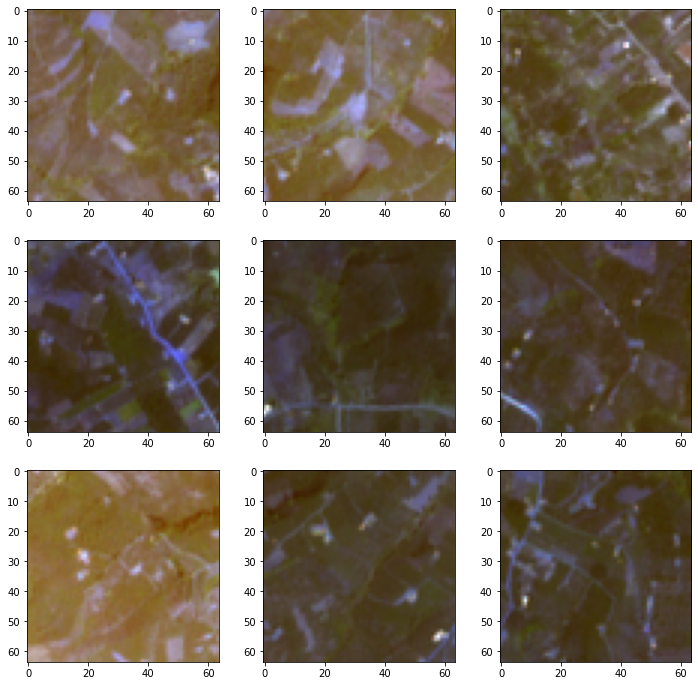

In [8]:
show_grid_img(path1)

### Create model

In [11]:
model = Sequential()
model.add(Input(2048))
model.add(Dropout(0.5))
model.add(Dense(64, activation=LeakyReLU(), kernel_regularizer=regularizers.l2(0.001)))
model.add(Dropout(0.5))
model.add(Dense(16, activation=LeakyReLU(), kernel_regularizer=regularizers.l2(0.001)))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 64)                131136    
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 16)                1040      
_________________________________________________________________
dropout_2 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 17        
Total params: 132,193
Trainable params: 132,193
Non-trainable params: 0
__________________________________________________

### Add earlystopper and tensorboard

In [12]:
RUN_NAME = '32x32'
LOGS_PATH = 'logs'
#os.mkdir(os.path.join(LOGS_PATH, RUN_NAME))


earlystopper = EarlyStopping(monitor='accuracy',patience=30,restore_best_weights=True)
tensorboard = TensorBoard(log_dir=os.path.join('logs', RUN_NAME),histogram_freq=1)

### Run model

In [13]:
LEARNING_RATE = 0.0001
DATA_AUGMENTATION_MULTIPLIATOR = 3

model.compile(optimizer=Adam(learning_rate=LEARNING_RATE), loss='binary_crossentropy',metrics=['accuracy'])

history = model.fit(train_generator,
                        epochs=70,
                        steps_per_epoch=int(len(path_train)/BATCH_SIZE),
                        validation_data=test_generator,
                        validation_steps=int(len(path_test)/BATCH_SIZE),
                        callbacks=[earlystopper, tensorboard])

Train for 83 steps, validate for 41 steps
Epoch 1/70
83/83 [==============================] - 143s 2s/step - loss: 1.2686 - accuracy: 0.5399 - val_loss: 0.7868 - val_accuracy: 0.6513
Epoch 2/70
83/83 [==============================] - 94s 1s/step - loss: 1.0222 - accuracy: 0.5847 - val_loss: 0.7613 - val_accuracy: 0.6734
Epoch 3/70
83/83 [==============================] - 79s 958ms/step - loss: 0.9544 - accuracy: 0.6005 - val_loss: 0.7486 - val_accuracy: 0.6944
Epoch 4/70
83/83 [==============================] - 74s 888ms/step - loss: 0.9217 - accuracy: 0.6152 - val_loss: 0.7394 - val_accuracy: 0.6940
Epoch 5/70
83/83 [==============================] - 72s 867ms/step - loss: 0.8979 - accuracy: 0.6194 - val_loss: 0.7241 - val_accuracy: 0.7039
Epoch 6/70
83/83 [==============================] - 71s 856ms/step - loss: 0.8830 - accuracy: 0.6286 - val_loss: 0.7221 - val_accuracy: 0.7054
Epoch 7/70
83/83 [==============================] - 71s 851ms/step - loss: 0.8490 - accuracy: 0.6323 - va

Epoch 58/70
83/83 [==============================] - 70s 848ms/step - loss: 0.6795 - accuracy: 0.6822 - val_loss: 0.6492 - val_accuracy: 0.7416
Epoch 59/70
83/83 [==============================] - 71s 850ms/step - loss: 0.6821 - accuracy: 0.6999 - val_loss: 0.6394 - val_accuracy: 0.7355
Epoch 60/70
83/83 [==============================] - 70s 847ms/step - loss: 0.6847 - accuracy: 0.6931 - val_loss: 0.6508 - val_accuracy: 0.7268
Epoch 61/70
83/83 [==============================] - 70s 845ms/step - loss: 0.6911 - accuracy: 0.6862 - val_loss: 0.6397 - val_accuracy: 0.7355
Epoch 62/70
83/83 [==============================] - 70s 847ms/step - loss: 0.6824 - accuracy: 0.6860 - val_loss: 0.6430 - val_accuracy: 0.7420
Epoch 63/70
83/83 [==============================] - 70s 847ms/step - loss: 0.6838 - accuracy: 0.6873 - val_loss: 0.6555 - val_accuracy: 0.7184
Epoch 64/70
83/83 [==============================] - 70s 848ms/step - loss: 0.6615 - accuracy: 0.7046 - val_loss: 0.6497 - val_accuracy:

### Save model

In [14]:
SAVED_MODELS_PATH = 'saved_models'
os.mkdir(os.path.join(SAVED_MODELS_PATH, RUN_NAME))

model.save(os.path.join(SAVED_MODELS_PATH, RUN_NAME, RUN_NAME + '.h5'))

np.save(os.path.join(SAVED_MODELS_PATH, RUN_NAME, RUN_NAME + '.npy'),history.history)

### Train and test accuracy/error

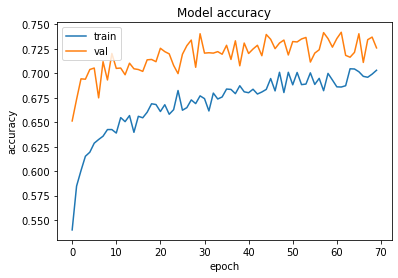

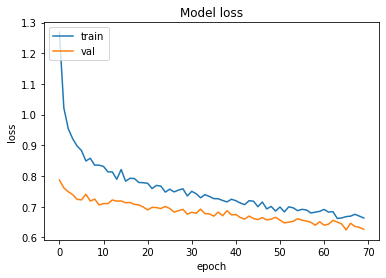

In [15]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

### Evaluate generator

In [16]:
test_generator = keras_layer_generator(path_test, y_test, eurosat_mean, eurosat_std, hub_layer, batch_size=BATCH_SIZE)
model.evaluate_generator(test_generator,30)

[0.6493916531403859, 0.7135417]

### Compute confusion matrix and metrics

In [18]:
Y_true = []
Y_pred = []
for i in range (0,30):
    X, Y = next(test_generator)
    Y_pred.extend(model.predict_classes(X))

    Y_true.extend(Y.tolist())
    
Y_true = np.asarray(Y_true)
Y_pred = np.asarray(Y_pred)

In [19]:
cm = confusion_matrix(Y_true, Y_pred)

In [20]:
cm

array([[729, 244],
       [275, 672]], dtype=int64)

In [21]:
print(classification_report(Y_true, Y_pred))
print(f"F1-Score : {f1_score(Y_true, Y_pred)}")

              precision    recall  f1-score   support

           0       0.73      0.75      0.74       973
           1       0.73      0.71      0.72       947

    accuracy                           0.73      1920
   macro avg       0.73      0.73      0.73      1920
weighted avg       0.73      0.73      0.73      1920

F1-Score : 0.7214170692431562


## Culture vs No culture
### Split culture and no culture class

In [7]:
culture_list = [1,2,6,15,18,19,17] #  6 caoutchou, 25 poivre de cayenne, 16 cassava, 23 intercrop
no_culture_list = [4,9,10, 24,27] # 11 other tree, 27 pines tree

nb_culture = 0
for c in culture_list:
    nb_culture+= len(os.listdir(os.path.join(IMAGES_DIR, str(c))))

nb_no_culture = 0
for c in no_culture_list:
    nb_no_culture+= len(os.listdir(os.path.join(IMAGES_DIR, str(c))))

### Histogramm of class repartition

Text(0.5, 1.0, 'Number of images by classes')

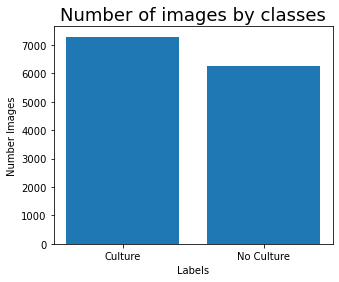

In [8]:
fig, ax = plt.subplots(figsize=(5,4))
ax.bar(['Culture', 'No Culture'], [nb_culture, nb_no_culture])
ax.set_xlabel('Labels')
ax.set_ylabel('Number Images')
ax.set_title('Number of images by classes', fontsize=18)

### Get images path on disk

In [9]:
path_culture = []

for c in culture_list:
    for name in os.listdir(os.path.join(IMAGES_DIR, str(c))):
        path_culture.append(os.path.join(IMAGES_DIR, str(c), name))
class_culture = [0]*len(path_culture)
        
path_no_culture = []

for c in no_culture_list:
    for name in os.listdir(os.path.join(IMAGES_DIR, str(c))):
        path_no_culture.append(os.path.join(IMAGES_DIR, str(c), name))
class_no_culture = [1]*len(path_no_culture)



### Split train/test and create generator

In [10]:
BATCH_SIZE = 64

file_paths = np.asarray(path_culture + path_no_culture)
classes = np.asarray(class_culture + class_no_culture)

path_train, path_test, y_train, y_test = train_test_split(file_paths, classes, test_size=0.25)
train_generator = keras_layer_generator(path_train, y_train, eurosat_mean, eurosat_std, hub_layer, batch_size=BATCH_SIZE)
test_generator = keras_layer_generator(path_test, y_test, eurosat_mean, eurosat_std, hub_layer, batch_size=BATCH_SIZE)

### Create model

In [11]:
model_culture = Sequential()
model_culture.add(Input(2048))
model_culture.add(Dropout(0.5))
model_culture.add(Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model_culture.add(Dropout(0.5))
model_culture.add(Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model_culture.add(Dropout(0.5))
model_culture.add(Dense(1, activation='sigmoid'))

model_culture.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               262272    
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                4128      
_________________________________________________________________
dropout_2 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 266,433
Trainable params: 266,433
Non-trainable params: 0
__________________________________________________

### Add earlystopper and tensorboard

In [12]:
RUN_NAME = '32x32culture'
LOGS_PATH = 'logs'
#os.mkdir(os.path.join(LOGS_PATH, RUN_NAME))


earlystopper = EarlyStopping(monitor='accuracy',patience=30,restore_best_weights=True)
tensorboard = TensorBoard(log_dir=os.path.join('logs', RUN_NAME),histogram_freq=1)

### Train model

In [13]:
LEARNING_RATE = 0.0001
DATA_AUGMENTATION_MULTIPLIATOR = 3

model_culture.compile(optimizer=Adam(learning_rate=LEARNING_RATE), loss='binary_crossentropy',metrics=['accuracy'])

history = model_culture.fit(train_generator,
                        epochs=100,
                        steps_per_epoch=int(len(path_train)/BATCH_SIZE)*DATA_AUGMENTATION_MULTIPLIATOR,
                        validation_data=test_generator,
                        validation_steps=int(len(path_test)/BATCH_SIZE)*DATA_AUGMENTATION_MULTIPLIATOR,
                        callbacks=[earlystopper, tensorboard])

Train for 474 steps, validate for 156 steps
Epoch 1/100
474/474 [==============================] - 795s 2s/step - loss: 1.0842 - accuracy: 0.5863 - val_loss: 0.8801 - val_accuracy: 0.7191
Epoch 2/100
474/474 [==============================] - 401s 847ms/step - loss: 0.9309 - accuracy: 0.6511 - val_loss: 0.8437 - val_accuracy: 0.7342
Epoch 3/100
474/474 [==============================] - 407s 859ms/step - loss: 0.8737 - accuracy: 0.6836 - val_loss: 0.8197 - val_accuracy: 0.7416
Epoch 4/100
474/474 [==============================] - 394s 830ms/step - loss: 0.8502 - accuracy: 0.6935 - val_loss: 0.8110 - val_accuracy: 0.7289
Epoch 5/100
474/474 [==============================] - 372s 786ms/step - loss: 0.8310 - accuracy: 0.7029 - val_loss: 0.7995 - val_accuracy: 0.7278
Epoch 6/100
474/474 [==============================] - 363s 765ms/step - loss: 0.8086 - accuracy: 0.7088 - val_loss: 0.7757 - val_accuracy: 0.7355
Epoch 7/100
474/474 [==============================] - 386s 815ms/step - loss

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



474/474 [==============================] - 361s 762ms/step - loss: 0.6310 - accuracy: 0.7460 - val_loss: 0.6048 - val_accuracy: 0.7612
Epoch 19/100
474/474 [==============================] - 361s 761ms/step - loss: 0.6268 - accuracy: 0.7460 - val_loss: 0.6006 - val_accuracy: 0.7584
Epoch 20/100
474/474 [==============================] - 360s 761ms/step - loss: 0.6163 - accuracy: 0.7513 - val_loss: 0.5966 - val_accuracy: 0.7604
Epoch 21/100
474/474 [==============================] - 360s 759ms/step - loss: 0.6126 - accuracy: 0.7457 - val_loss: 0.5904 - val_accuracy: 0.7618
Epoch 22/100
474/474 [==============================] - 360s 759ms/step - loss: 0.6028 - accuracy: 0.7500 - val_loss: 0.5784 - val_accuracy: 0.7670
Epoch 23/100
474/474 [==============================] - 360s 760ms/step - loss: 0.5957 - accuracy: 0.7509 - val_loss: 0.5804 - val_accuracy: 0.7564
Epoch 24/100
474/474 [==============================] - 360s 760ms/step - loss: 0.5869 - accuracy: 0.7541 - val_loss: 0.5718 

### Save model

In [14]:
os.mkdir(os.path.join(SAVED_MODELS_PATH, RUN_NAME))

model_culture.save(os.path.join(SAVED_MODELS_PATH, RUN_NAME, RUN_NAME + '.h5'))

np.save(os.path.join(SAVED_MODELS_PATH, RUN_NAME, RUN_NAME + '.npy'),history.history)

### Train and test accuracy/error

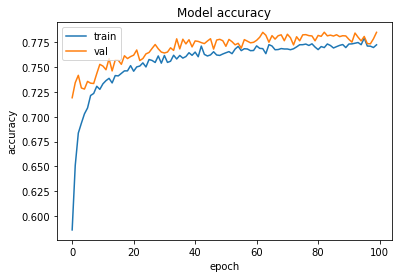

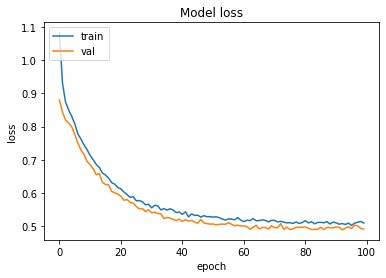

In [15]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

### Evaluate model

In [16]:
model_culture.evaluate_generator(test_generator,30)

[0.49332220753033956, 0.77552086]

### Compute confusion matrix and metrics

In [18]:
test_generator = keras_layer_generator(path_test, y_test, eurosat_mean, eurosat_std, hub_layer,batch_size=BATCH_SIZE)

Y_true = []
Y_pred = []
for i in range (0,30):
    X, Y = next(test_generator)
    Y_pred.extend(model_culture.predict_classes(X))

    Y_true.extend(Y.tolist())
    
Y_true = np.asarray(Y_true)
Y_pred = np.asarray(Y_pred)

In [19]:
cm = confusion_matrix(Y_true, Y_pred)
cm

array([[885, 121],
       [296, 618]], dtype=int64)

In [20]:
print(classification_report(Y_true, Y_pred))
print(f"F1-Score : {f1_score(Y_true, Y_pred)}")

              precision    recall  f1-score   support

           0       0.75      0.88      0.81      1006
           1       0.84      0.68      0.75       914

    accuracy                           0.78      1920
   macro avg       0.79      0.78      0.78      1920
weighted avg       0.79      0.78      0.78      1920

F1-Score : 0.7477313974591652


# Performance 64x64 vs 32x32

## Coffee vs other

In [60]:
history32 = np.load(os.path.join(SAVED_MODELS_PATH, '32x32','32x32.npy'),allow_pickle='TRUE').item()
history64 = np.load(os.path.join(SAVED_MODELS_PATH, 'augmented1','augmented1.npy'),allow_pickle='TRUE').item()

### Accuracy

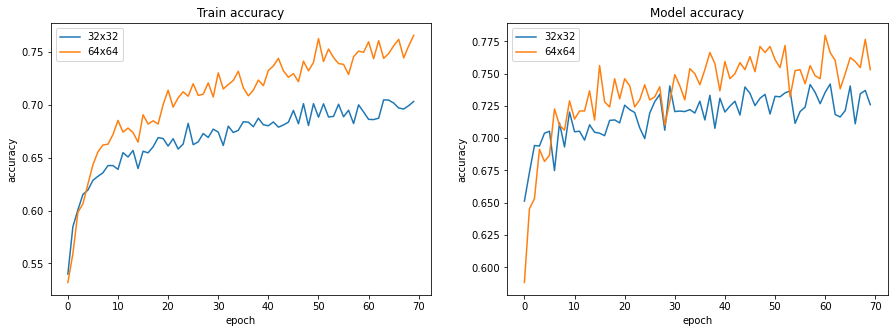

In [61]:
fig, axes = plt.subplots(1,2, figsize=(15,5))
# summarize history for accuracy
axes[0].plot(history32['accuracy'])
axes[0].plot(history64['accuracy'])
axes[0].set_title('Train accuracy')
axes[0].set_ylabel('accuracy')
axes[0].set_xlabel('epoch')
axes[0].legend(['32x32', '64x64'], loc='upper left')

axes[1].plot(history32['val_accuracy'])
axes[1].plot(history64['val_accuracy'])
axes[1].set_title('Model accuracy')
axes[1].set_ylabel('accuracy')
axes[1].set_xlabel('epoch')
axes[1].legend(['32x32', '64x64'], loc='upper left')

Text(0, 0.5, 'Accuracy')

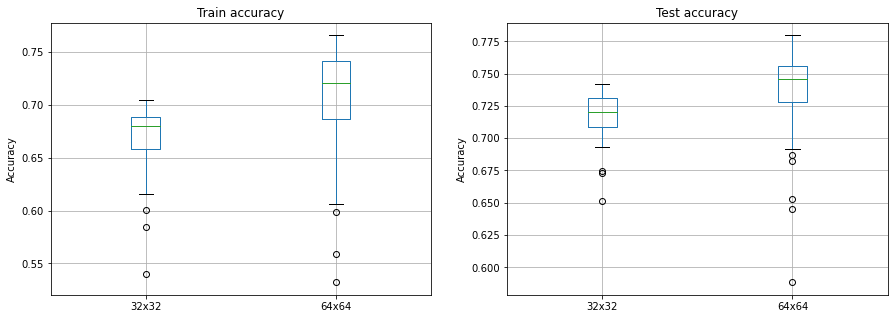

In [62]:
fig, axes = plt.subplots(1,2, figsize=(15,5))

pd.DataFrame({'32x32':history32['accuracy'], '64x64':history64['accuracy']}).boxplot(ax=axes[0])
pd.DataFrame({'32x32':history32['val_accuracy'], '64x64':history64['val_accuracy']}).boxplot(ax=axes[1])
axes[0].set_title('Train accuracy')
axes[0].set_ylabel('Accuracy')

axes[1].set_title('Test accuracy')
axes[1].set_ylabel('Accuracy')

### Loss

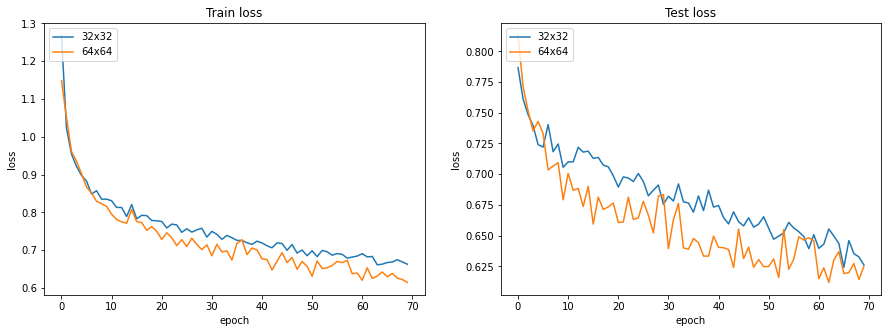

In [63]:
fig, axes = plt.subplots(1,2, figsize=(15,5))
# summarize history for accuracy
axes[0].plot(history32['loss'])
axes[0].plot(history64['loss'])
axes[0].set_title('Train loss')
axes[0].set_ylabel('loss')
axes[0].set_xlabel('epoch')
axes[0].legend(['32x32', '64x64'], loc='upper left')

axes[1].plot(history32['val_loss'])
axes[1].plot(history64['val_loss'])
axes[1].set_title('Test loss')
axes[1].set_ylabel('loss')
axes[1].set_xlabel('epoch')
axes[1].legend(['32x32', '64x64'], loc='upper left')

Text(0, 0.5, 'Loss')

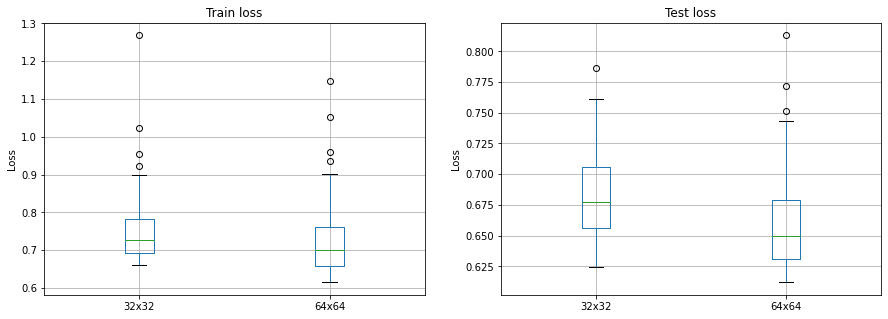

In [64]:
fig, axes = plt.subplots(1,2, figsize=(15,5))

pd.DataFrame({'32x32':history32['loss'], '64x64':history64['loss']}).boxplot(ax=axes[0])
pd.DataFrame({'32x32':history32['val_loss'], '64x64':history64['val_loss']}).boxplot(ax=axes[1])
axes[0].set_title('Train loss')
axes[0].set_ylabel('Loss')

axes[1].set_title('Test loss')
axes[1].set_ylabel('Loss')

## Culture vs no culture

In [67]:
history32 = np.load(os.path.join(SAVED_MODELS_PATH, '32x32culture','32x32culture.npy'),allow_pickle='TRUE').item()
history64 = np.load(os.path.join(SAVED_MODELS_PATH, 'culture3','culture3.npy'),allow_pickle='TRUE').item()

### Accuracy

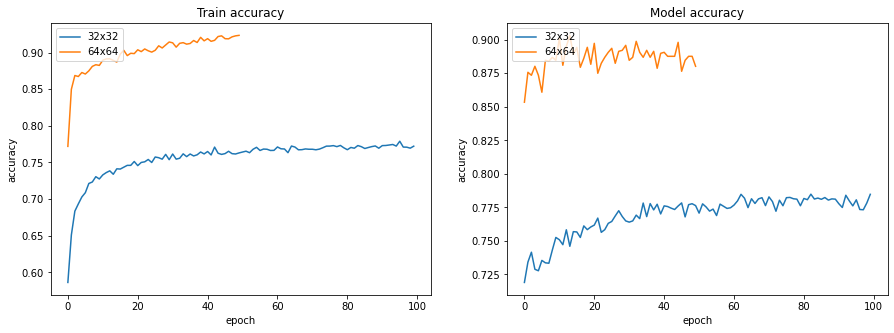

In [68]:
fig, axes = plt.subplots(1,2, figsize=(15,5))
# summarize history for accuracy
axes[0].plot(history32['accuracy'])
axes[0].plot(history64['accuracy'])
axes[0].set_title('Train accuracy')
axes[0].set_ylabel('accuracy')
axes[0].set_xlabel('epoch')
axes[0].legend(['32x32', '64x64'], loc='upper left')

axes[1].plot(history32['val_accuracy'])
axes[1].plot(history64['val_accuracy'])
axes[1].set_title('Model accuracy')
axes[1].set_ylabel('accuracy')
axes[1].set_xlabel('epoch')
axes[1].legend(['32x32', '64x64'], loc='upper left')

### Loss

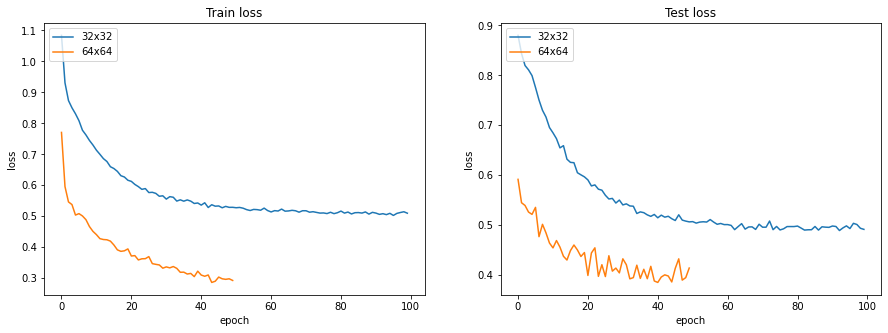

In [70]:
fig, axes = plt.subplots(1,2, figsize=(15,5))
# summarize history for accuracy
axes[0].plot(history32['loss'])
axes[0].plot(history64['loss'])
axes[0].set_title('Train loss')
axes[0].set_ylabel('loss')
axes[0].set_xlabel('epoch')
axes[0].legend(['32x32', '64x64'], loc='upper left')

axes[1].plot(history32['val_loss'])
axes[1].plot(history64['val_loss'])
axes[1].set_title('Test loss')
axes[1].set_ylabel('loss')
axes[1].set_xlabel('epoch')
axes[1].legend(['32x32', '64x64'], loc='upper left')